In [34]:
import pandas as pd

In [181]:
df = pd.read_parquet('../data/processed/newest_dataset.parquet')

# Convert 'date' column to datetime (if it isn't already)
df['date'] = pd.to_datetime(df['date'], errors='coerce') 

# Extract the year from the 'date' column and create a new 'year' column
df['year'] = df['date'].dt.year.astype(int)

df.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice,countryiso3,country,Value,Unit,standardprice,year
0,2014-01-15,None,Eswatini,National Average,-26.3044,31.1344,cereals and tubers,Maize meal,KG,actual,Retail,SZL,8.94,0.8232,SWZ,Eswatini,1.0,1 KG,0.8232,2014
1,2014-01-15,None,Eswatini,National Average,-26.3044,31.1344,cereals and tubers,Rice,KG,actual,Retail,SZL,10.79,0.9936,SWZ,Eswatini,1.0,1 KG,0.9936,2014
2,2014-01-15,None,Eswatini,National Average,-26.3044,31.1344,cereals and tubers,Wheat flour,KG,actual,Retail,SZL,11.85,1.0912,SWZ,Eswatini,1.0,1 KG,1.0912,2014
3,2014-01-15,None,Eswatini,National Average,-26.3044,31.1344,miscellaneous food,Sugar (brown),KG,actual,Retail,SZL,10.21,0.9401,SWZ,Eswatini,1.0,1 KG,0.9401,2014
4,2014-01-15,None,Eswatini,National Average,-26.3044,31.1344,pulses and nuts,Beans (sugar),KG,actual,Retail,SZL,24.50,2.2560,SWZ,Eswatini,1.0,1 KG,2.2560,2014


In [144]:
print(df['commodity'].unique())

['Maize meal' 'Rice' 'Wheat flour' 'Sugar (brown)' 'Beans (sugar)' 'Bread'
 'Bread (brown)' 'Salt' 'Cabbage' 'Potatoes' 'Maize (white)'
 'Oil (sunflower)' 'Oil (cooking)' 'Rice (mixed, low quality)' 'Soybeans'
 'Prawn' 'Meat (pork, with fat)' 'Oil (vegetable)' 'Eggs (duck)'
 'Beans (yardlong, green)' 'Cabbage (chinese, flowering)'
 'Fish (snake head)' 'Fish (striped catfish)' 'Salt (iodised)' 'Wax gourd'
 'Fish (catfish)' 'Eggplants' 'Snake gourd' 'Water spinach'
 'Eggs (duck, fermented)' 'Fish (snake head, dry)' 'Fish sauce (lobster)'
 'Bean (mung, dry)' 'Groundnuts' 'Soybeans (dry)' 'Bananas (ripe)'
 'Garlic' 'Tamarind (ripe)' 'Meat (beef, fat, without bones)'
 'Meat (chicken)' 'Bananas flower' 'Cauliflower'
 'Eggplants (white, round)' 'Gourd (ridge)' 'Papaya (green)'
 'Tomatoes (red, ripe)' 'Fish paste (red, fermented)'
 'Cabbage (chinese, raw)' 'Ivygourd leaves' 'Kale (chinese)'
 'Moringa leaves' 'Mustard leaves' 'Pumpkin leaves' 'Sauropus sp. leaves'
 'Carrots' 'Pumpkin' 'Amaranth

In [145]:
print(df['Unit'].unique())

['1 KG' 'Head' '1 L' '1 piece' 'Tubers' 'Bunch' 'Unit' 'Packet' 'piece'
 'Dozens' 'Box' 'Dozen' 'Heap' 'Day' 'Bundle' 'Package' 'Pile' 'Marmite'
 'Cuartilla']


In [202]:
pd.set_option('display.max_rows', None)
commodity_units = df.groupby(['country', 'commodity', 'Unit'])['standardprice'].mean().reset_index()
print(commodity_units[commodity_units['Unit'] == 'Box'])

        country               commodity Unit  standardprice
1043  Guatemala               Cucumbers  Box       8.214563
1079  Guatemala                  Radish  Box       4.147282
1089  Guatemala     Tomatoes (big size)  Box      14.817562
1090  Guatemala  Tomatoes (medium size)  Box      12.574317


In [182]:
# get adjusted national income per capita (USD) per country and year
nni = pd.read_csv('../data/raw/adjusted_net_national_income.csv')

# drop non-year columns
year_cols = [col for col in nni.columns if "[YR" in col] + ["Country Code"]
nni_filtered = nni[year_cols]

# melt the filtered DataFrame
nni_long = nni_filtered.melt(
    id_vars=["Country Code"],
    var_name="year",
    value_name="Adjusted NNI"
)

# clean up the 'year' column
nni_long['year'] = nni_long['year'].str.extract(r'(\d{4})')
nni_long['year'] = nni_long['year'].astype(int)

# drop rows where there's no NNI for that year
nni_long['Adjusted NNI'] = nni_long['Adjusted NNI'].replace('..', pd.NA)
nni_long = nni_long.dropna(subset=['Adjusted NNI'])

# change type
nni_long['Adjusted NNI'] = nni_long['Adjusted NNI'].astype(float)

print(nni_long)

     Country Code  year  Adjusted NNI
0             AFG  2009    403.411183
1             ALB  2009   3517.609153
2             DZA  2009   2960.306317
5             AGO  2009   1870.287448
7             ARG  2009   6808.995877
8             ARM  2009   2583.616131
9             ABW  2009  21733.074620
10            AUS  2009  33482.731900
11            AUT  2009  39649.394820
12            AZE  2009   3275.461603
13            BHS  2009  25106.339590
14            BHR  2009  13040.120380
15            BGD  2009    672.110603
16            BRB  2009  13917.374400
17            BLR  2009   4480.508001
18            BEL  2009  36866.049110
19            BLZ  2009   4069.969924
20            BEN  2009    882.976827
22            BTN  2009   1503.247340
23            BOL  2009   1453.727760
24            BIH  2009   4156.505046
25            BWA  2009   3900.709246
26            BRA  2009   6936.075263
28            BRN  2009  21015.534410
29            BGR  2009   5759.802811
30          

In [183]:
# calculate average standard price per country and year
avg_price = df.groupby(['country', 'countryiso3', 'year'])['standardprice'].mean().reset_index()

# outer join on 'countryiso3' = 'Country Code' and 'year' = 'year'
affordability_df = pd.merge(
    avg_price, 
    nni_long, 
    how='left', 
    left_on=['countryiso3', 'year'], 
    right_on=['Country Code', 'year']
)

affordability_df = affordability_df.drop(columns=['Country Code'])
affordability_df = affordability_df.dropna()
print(affordability_df)

                              country countryiso3  year  standardprice  \
0                         Afghanistan         AFG  2014       0.623119   
1                         Afghanistan         AFG  2015       0.556338   
2                         Afghanistan         AFG  2016       0.511449   
3                         Afghanistan         AFG  2017       0.517257   
4                         Afghanistan         AFG  2018       0.495619   
5                         Afghanistan         AFG  2019       0.483453   
6                         Afghanistan         AFG  2020       0.700478   
7                         Afghanistan         AFG  2021       0.729211   
11                            Algeria         DZA  2015       1.787312   
12                            Algeria         DZA  2016       1.739880   
13                            Algeria         DZA  2021       1.596099   
17                             Angola         AGO  2014       3.346540   
18                             Angola 

In [191]:
from sklearn.preprocessing import StandardScaler

# estimate annual food expense and annual food budget
affordability_df['est_annual_cost'] = affordability_df['standardprice'] * 15 * 52 # average 15 commodities per week
affordability_df['est_annual_budget'] = affordability_df['Adjusted NNI'] * 0.60 # assuming upper bound of 60% of annual income spent on food for lower income countries

# calculate the affordability ratio
affordability_df['affordability_ratio'] = affordability_df['est_annual_budget'] / affordability_df['est_annual_cost']

# find and filter out outliers
th = 5
# print(affordability_df[affordability_df['affordability_ratio'] > th])
affordability_df = affordability_df[affordability_df['affordability_ratio'] <= th]

# find the min and max affordability ratio in the dataset
min_ratio = affordability_df['affordability_ratio'].min()
max_ratio = affordability_df['affordability_ratio'].max()

# normalize affordability ratio to a 0-100 scale
affordability_df['affordability_index'] = 100 * (affordability_df['affordability_ratio'] - min_ratio) / (max_ratio - min_ratio)

# clip values to 0-100 range in case of any outliers
affordability_df['affordability_index'] = affordability_df['affordability_index'].clip(0, 100)

affordability_df.head()

,country,countryiso3,year,standardprice,Adjusted NNI,est_annual_cost,est_annual_budget,affordability_ratio,affordability_index
0,Afghanistan,AFG,2014,0.623119,575.916815,486.032472,345.550089,0.710961,14.293749
1,Afghanistan,AFG,2015,0.556338,548.968455,433.943282,329.381073,0.759042,15.260859
2,Afghanistan,AFG,2016,0.511449,484.890590,398.930500,290.934354,0.729286,14.662340
3,Afghanistan,AFG,2017,0.517257,497.406029,403.460392,298.443617,0.739710,14.872012
4,Afghanistan,AFG,2018,0.495619,466.570602,386.582563,279.942361,0.724146,14.558964


In [192]:
affordability_df['affordability_ratio'].describe()  # check the summary statistics

count    597.000000
mean       1.185841
std        1.063837
min        0.000333
25%        0.430953
50%        0.904727
75%        1.534514
max        4.971933
Name: affordability_ratio, dtype: float64

<Axes: >

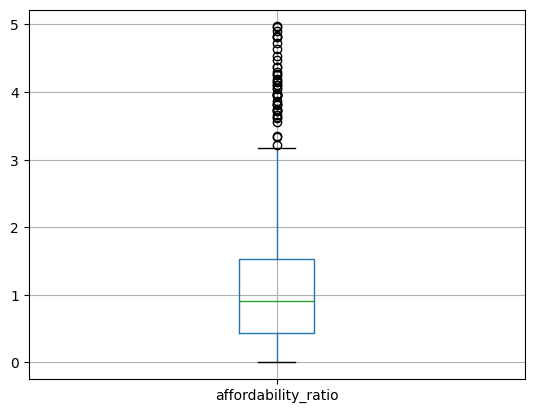

In [197]:
affordability_df.boxplot('affordability_ratio')

<Axes: >

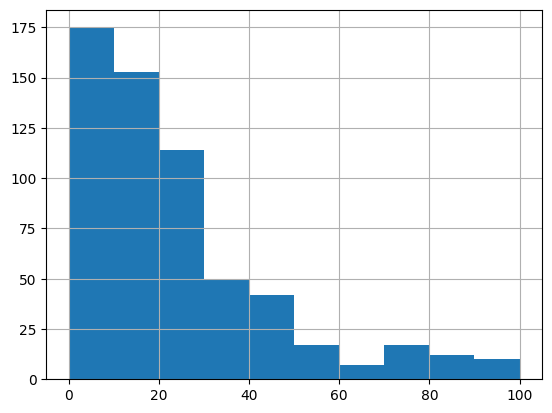

In [195]:
affordability_df['affordability_index'].hist()

In [203]:
affordability_df.to_csv('../data/processed/affordability_index.csv')